In [2]:
## tyyrhgfg

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

from sklearn.ensemble import RandomForestClassifier 
from imblearn.under_sampling import RandomUnderSampler

Create a class for the loader

In [58]:
class MyDataset(torch.utils.data.Dataset):

  def __init__(self,df_x, df_y):
    self.x_train=torch.tensor(df_x,dtype=torch.float32)
    self.y_train=torch.tensor(df_y,dtype=torch.float32)

  def __len__(self):
    return len(self.y_train)
  
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx] 

A function to process the DF. This will be useful to process the test set in the same way

In [4]:
def process_df(df):
    df = pd.get_dummies(df, columns = ["customer_children"], drop_first=True)
    df = pd.get_dummies(df, columns = ["customer_relationship"], drop_first=True)
    df["customer_gender"] = df["customer_gender"].replace(1,0).replace(2,1)

    # Dropping irrelevant variables
    df = df.drop(["customer_postal_code", "customer_since_all","customer_since_bank", "customer_occupation_code", "customer_education", "customer_birth_date"], axis = 1)
    return df

Process the DF

In [5]:
train_df = pd.read_csv("data/train_month_3_with_target.csv")

# Dummifying some variables
train_df = process_df(train_df)

y=train_df
y = y[["target"]]
X = train_df.drop(["target", "client_id"], axis = 1)

print(f"There are {np.sum(y)} churn cases in {len(y)}")

There are target    1913
dtype: int64 churn cases in 63697


Some EDA using **bal_savings_account**

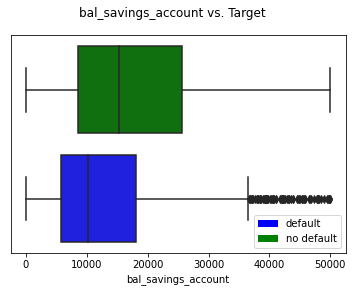

In [45]:
fig, ax = plt.subplots()

sns.boxplot(x="bal_savings_account", y="target", data=train_df, orient="h", palette={1:"blue", 0:"green"}, ax=ax)

ax.get_yaxis().set_visible(False)

fig.suptitle("bal_savings_account vs. Target")

color_patches = [
    Patch(facecolor="blue", label="default"),
    Patch(facecolor="green", label="no default")
]
ax.legend(handles=color_patches)

Get the correlation between the output and all the variables

In [34]:
import json
correlations = {}
best_cols = []

for col in X.columns:
    try:
        corr = np.corrcoef(X[col], y["target"])[1,0]
        if np.abs(corr) > 0.08:
            correlations[col] = corr
            best_cols.append(col)
    except:
        print(col)

with open('json_data.json', 'w') as outfile:
    json.dump(correlations, outfile)


customer_birth_date


This is how I used to to id before

Put it in the loaders

In [61]:
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.33, random_state=42)

training_set=MyDataset(X_train.values, y_train.values)
validation_set=MyDataset(X_val.values, y_val.values)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

Define the model and the hyperparameters

In [72]:
class Net(nn.Module):

    def __init__(self, input_size):
        super(Net, self).__init__()
        # # Define sigmoid activation and first layer
        self.linear = torch.nn.Linear(input_size, 1)
        self.Function = nn.LogSigmoid()

    # def forward(self, inputs):
    #     return self.Function(inputs)

    def forward(self, inputs):
        return self.Function(self.linear(inputs))


model = Net(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

This piece of code is useful to test the training

In [39]:
## Testing the loss
f = 1
for i, data in enumerate(training_loader):
    # Every data instance is an input + label pair
    inputs, labels = data
    outputs = model(inputs)
    # print(outputs.view(5), labels)
    loss = criterion(outputs, labels)
    print(loss.item())
    f += 1
    if f == 3:
        break

    


0.3187493681907654
0.22621630132198334


This is the training and the prediction part

In [73]:

def train_one_epoch(epoch_index): #, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number) #, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        print('model_{}_{}'.format(timestamp, epoch_number))

    epoch_number += 1

# y.to_csv(f"{timestamp}_train.csv", index = None)

EPOCH 1:
  batch 1000 loss: 382.70996875
  batch 2000 loss: 0.03
  batch 3000 loss: 0.02475
  batch 4000 loss: 0.0295
  batch 5000 loss: 0.035
  batch 6000 loss: 0.02925
  batch 7000 loss: 0.02875
  batch 8000 loss: 0.03475
  batch 9000 loss: 0.03025
  batch 10000 loss: 0.03125
LOSS train 0.03125 valid 0.0298230592161417
model_20220404_175704_0
EPOCH 2:
  batch 1000 loss: 0.031
  batch 2000 loss: 0.0285
  batch 3000 loss: 0.02775
  batch 4000 loss: 0.03175
  batch 5000 loss: 0.03075
  batch 6000 loss: 0.0305
  batch 7000 loss: 0.02825
  batch 8000 loss: 0.0275
  batch 9000 loss: 0.03175
  batch 10000 loss: 0.03425
LOSS train 0.03425 valid 0.0298230592161417
EPOCH 3:
  batch 1000 loss: 0.0305
  batch 2000 loss: 0.0315
  batch 3000 loss: 0.02975
  batch 4000 loss: 0.0285
  batch 5000 loss: 0.02825
  batch 6000 loss: 0.03475
  batch 7000 loss: 0.03125
  batch 8000 loss: 0.02825
  batch 9000 loss: 0.02725
  batch 10000 loss: 0.031
LOSS train 0.031 valid 0.0298230592161417
EPOCH 4:
  batch 

In [75]:
test_df = pd.read_csv("data/test_month_3.csv")

test_df = process_df(test_df)

df_pred = pd.DataFrame()
df_pred["ID"] = test_df["client_id"]

X_test = test_df.drop(["client_id"], axis = 1)

# X_test = X_test[best_cols]

new_data = torch.tensor(X_test.values).type(torch.FloatTensor)
old_data = torch.tensor(X.values).type(torch.FloatTensor)
with torch.no_grad():
    prediction = model(new_data)
    train_data = model(old_data)

df_pred["PROB"] = prediction.squeeze().data.detach().numpy()
y["PROB"] = train_data.squeeze().data.detach().numpy()

df_pred.to_csv(f"{timestamp}_attempt.csv", index = None)
# y.to_csv(f"{timestamp}_target.csv", index = None)

/tmp/ipykernel_19368/1868732702.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["PROB"] = train_data.squeeze().data.detach().numpy()


# Random Forest Classifier

In [76]:
samplingstrat=0.5
rus= RandomUnderSampler(sampling_strategy=samplingstrat,random_state=0)
X_train_under, y_train_under=rus.fit_resample(X_train,y_train)

print(X_train_under.shape)
print(y_train_under.shape,y_train_under.sum())

(3858, 38)
(3858, 1) target    1286
dtype: int64


In [77]:
Rdfclf= RandomForestClassifier(n_estimators=200,random_state=20)
Rdfclf.fit(X_train_under,y_train_under)


y_pred_under=Rdfclf.predict(X_test)

# print(confusion_matrix(y_test,y_pred_under))
# print(accuracy_score(y_test,y_pred_under))
# print(classification_report(y_test,y_pred_under))

/tmp/ipykernel_19368/3226531153.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Rdfclf.fit(X_train_under,y_train_under)


In [81]:
y_pred_under

array([1, 0, 1, ..., 0, 0, 0])